**Table of contents**<a id='toc0_'></a>    
- 1. [Perturbed pulse-oscillators  ](#toc1_)    
- 2. [Model setup ](#toc2_)    
- 3. [Compute the correlation distance for the simulation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Perturbed pulse-oscillators   [&#128285;](#toc0_)

In [151]:
# Imports
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patheffects as pe

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

# 2. <a id='toc2_'></a>Model setup  [&#128285;](#toc0_)

In [103]:
# Simulation parameters
# --> Single oscillator parameters
I = 1.1  # input charging rate [charge / time]
alpha = 1  # leakage rate [1 / time]
p = 0.1  # event pulse intensity [charge]

osc_period = 1/alpha * np.log(I/(I-alpha))
print('Period of firing will be about T = {:.2f}\n'.format(osc_period))

# --> Multi-oscillator paramters
Nx = 1000  # number of oscillators in the line (also number of spatial points)

# --> Randomness parameters
std = 0.023
alpha_noisy = alpha + std * np.random.randn(Nx)
print('{:}/{:} oscillators will only fire when triggered'.format(np.sum(alpha_noisy > I), Nx))

# --> Perturbation parameters
perturbation_rate = 1 / osc_period  # rate of perturbation [1 / time] at a given oscillator
perturbation_intensity = p / 2  # intensity of the perturbation [charge]

spatial_period = Nx  # period of the spatial perturbation [space units]
spatial_perturbation_rate = perturbation_rate * ((np.cos(np.linspace(0., np.pi/(spatial_period/Nx), Nx)) + 1)/2)**2 # spatial rate of perturbation [1 / time]

Period of firing will be about T = 2.40

0/1000 oscillators will only fire when triggered


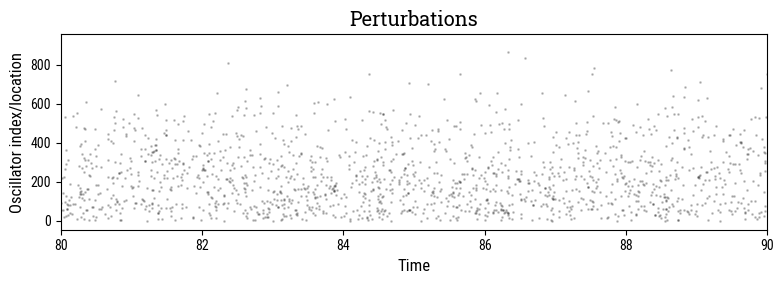

In [104]:
# Set up the numerical system and perturbations
# --> Numerical parameters
total_time = 100
dt = 0.001
t = np.arange(0, total_time, dt)

# --> Perturbations
perturbations = np.random.rand(len(t), Nx) < spatial_perturbation_rate[np.newaxis, :] * dt  # perturbation matrix (Nt, Nx), 1 when/where perturbation occurs
perturbation_times = np.where(perturbations)[0] * dt  # times of perturbations [time]
perturbation_idx = np.where(perturbations)[1]  # indices (locations) of perturbations [space]

# Show perturbations
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xlabel('Time')
ax.set_ylabel('Oscillator index/location')
ax.set_title('Perturbations', fontname='Roboto Slab')
ax.plot(perturbation_times, perturbation_idx, 'o', color=to_rgba('k', .2), markersize=1)

ax.set_xlim(80, 90)

plt.tight_layout()
plt.show()

In [105]:
# Set up the numerical system and run
# --> Numerical parameters
total_time = 100
dt = 0.001
t = np.arange(0, total_time, dt)

# Solve
# --> Initial state
y = np.random.rand(len(t), Nx)
firing_times = []
firing_idx = []

# --> Update
for ii in range(1, len(t)):
    print('Timestep {}/{}'.format(ii, len(t)), end='\r')
    # --> Internal dynamic: charge increment
    y[ii, :] = y[ii-1, :] + dt * (I - y[ii-1, :] * alpha_noisy)

    # --> Outside perturbations
    y[ii, :] += perturbations[ii, :] * perturbation_intensity
    
    if np.any(y[ii, :] > 1):
        firing = np.where(y[ii, :] > 1)[0]
        left = firing - 1
        left = left[left >= 0]  # remove sides
        right = firing + 1
        right = right[right < Nx]  # remove sides
        left_and_right = np.unique(np.concatenate((left, right)))

        # Fire
        y[ii, firing] = 0
        y[ii, left_and_right] += p

        # Store
        firing_times.extend(t[ii] * np.ones(len(firing)))
        firing_idx.extend(firing)



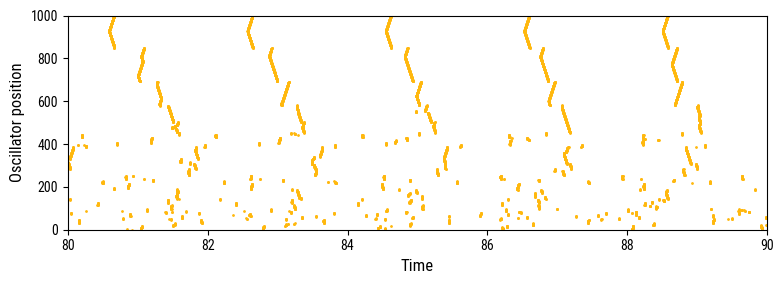

In [106]:
# Show results of the simulation
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.set_xlabel('Time')
ax.set_ylabel('Oscillator position')

ax.plot(firing_times, firing_idx, 'o', ms=1, color='C2')

ax.set_xlim(80, 90)
ax.set_ylim(0, Nx)

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Compute the correlation distance for the simulation [&#128285;](#toc0_)

Migration speed is 13.32 km/day


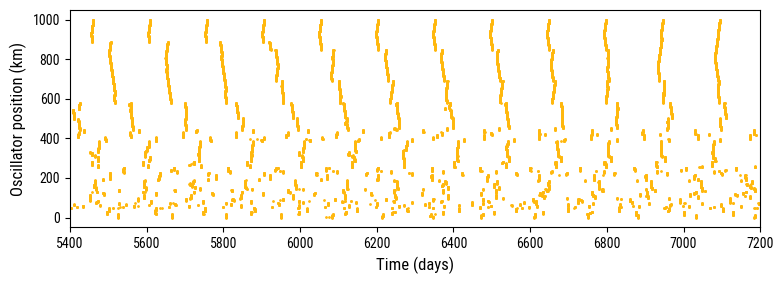

In [107]:
# Set scales
# --> Physical scales
T = 6.*30. / osc_period # Time scale [days]: number of days that correspond to 1 unit of time in simulation
L = 1000. / Nx # Length scale [km]: number of kilometers that correspond to 1 unit of space in simulation

ev_t = np.array(firing_times) * T
ev_x = np.array(firing_idx) * L

print('Migration speed is {:.2f} km/day'.format( (1*L)/(dt * T)))

# Show scaled results
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.set_xlabel('Time (days)')
ax.set_ylabel('Oscillator position (km)')

ax.plot(ev_t, ev_x, 'o', ms=1, color='C2')

ax.set_xlim(30*osc_period*T, 40*osc_period*T)
plt.tight_layout()
plt.show()

In [108]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 0
xmax_bin = Nx * L
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1.  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 5  # in km/day

In [109]:
# --> Make the counts
tmin = 30 * osc_period * T  # start after the progressive synchronization
tmax = 40

count_time = np.arange(tmin, ev_t.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    ev_in_bin = (ev_x >= x_min) & (ev_x < x_max)
    counts[ii, :] = np.histogram(ev_t[ev_in_bin], bins=count_time)[0]

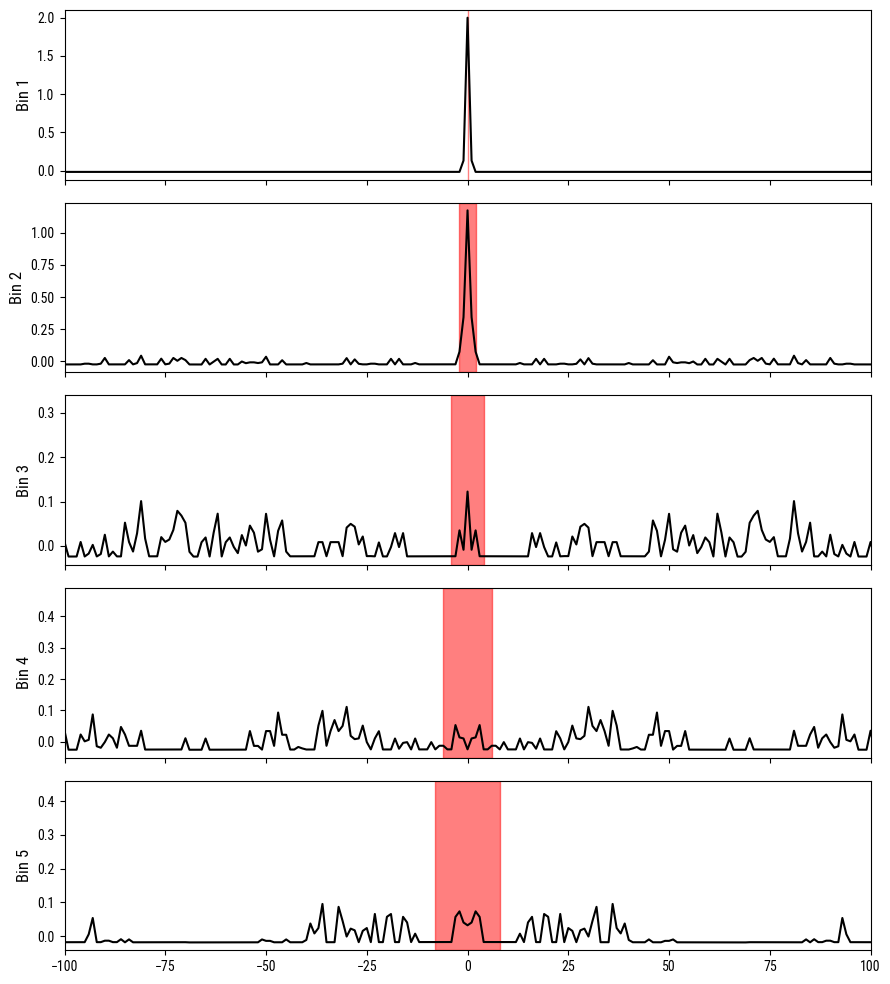

In [110]:
# Look at the cross correlations
ibin = 20 # index of the count to look at
N_counts = 5  # number bins away from the bin to look at the cross-correlation function
cc, lag = cross_corr(counts[ibin, :], counts[ibin+N_counts, :], delta, norm=norm, no_bias=no_bias)  # retrieve the size of the cross-correlation

cross_corrs = np.zeros((N_counts+1, cc.shape[0]))
for ii in range(ibin, ibin+N_counts):
    cross_corrs[ii-ibin, :], _ = cross_corr(counts[ibin, :], counts[ii, :], delta, norm=norm, no_bias=no_bias)

fig, axes = plt.subplots(N_counts, 1, figsize=(9, 2*N_counts), sharex=True)
for ii, ax in enumerate(axes):
    ax.plot(lag, cross_corrs[ii, :]+cross_corrs[ii, ::-1], c='k')
    ax.set_ylabel(f'Bin {ii+1}')

    ax.axvspan(-ii*dx_bin/v_min, ii*dx_bin/v_min, color=to_rgba('r', .5), zorder=0)

ax.set_xlim(-100, 100)

plt.tight_layout()
plt.show()


In [111]:
# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    print('Bin {}/{}'.format(ii, len(x_bin_edges)-1), end='\r')
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

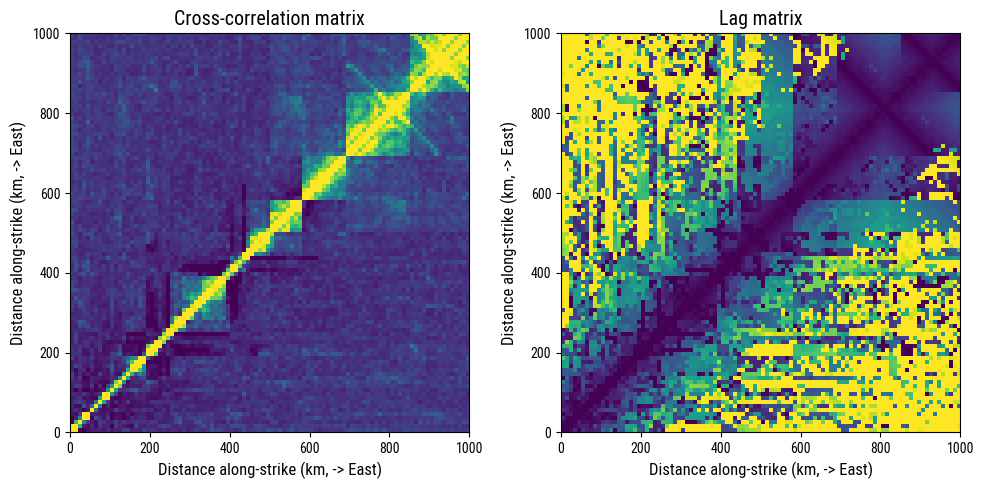

In [112]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

cax = ax.imshow(cc_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], origin='lower', cmap='viridis', vmin=0, vmax=.4)
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

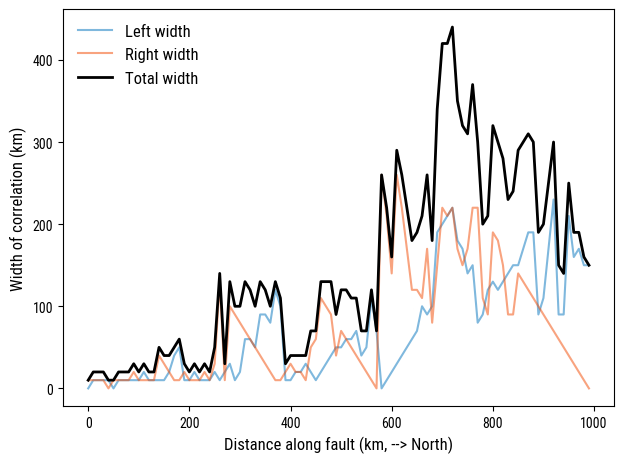

In [113]:
# Look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', lw=2)
ax.legend()
plt.tight_layout()
plt.show()

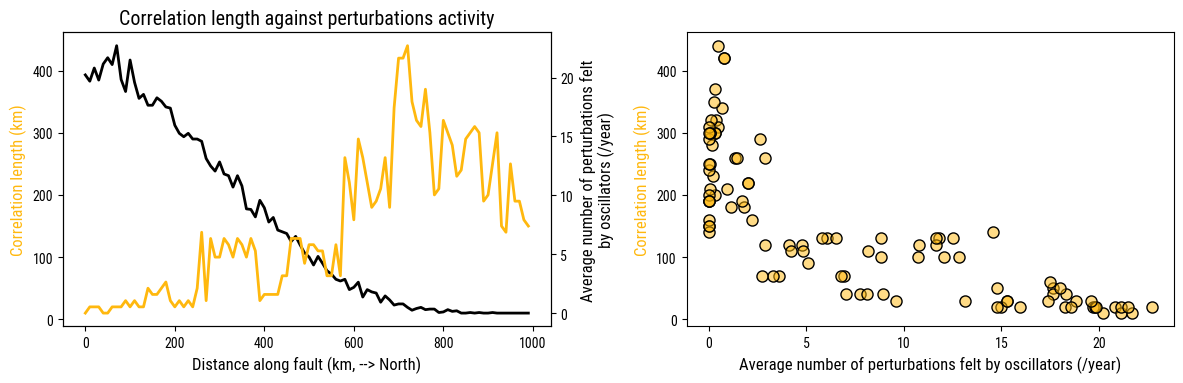

In [117]:
# Against perturbation activity
perturbation_hist, _ = np.histogram(perturbation_idx*L, bins=x_bin_edges)
spatial_perturbation_yearly = perturbation_hist / (total_time*T / 365)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against perturbations activity')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of perturbations felt\nby oscillators (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], spatial_perturbation_yearly, 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of perturbations felt by oscillators (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(spatial_perturbation_yearly, corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [116]:
# Save simulation
save = True

if save:
    parameters = {
        'I': I,
        'alpha': alpha,
        'alpha_std': std,
        'p': p,
        'osc_period': osc_period,
        'Nx': Nx,
        'dt': dt,
        'total_time': total_time,
        'spatial_perturbation_rate': spatial_perturbation_rate,
        'perturbation_intensity': perturbation_intensity,
        'time_scale': T,
        'length_scale': L
    }

    results = {
        'firing_times': firing_times,
        'firing_idx': firing_idx,
        'perturbation_times': perturbation_times,
        'perturbation_idx': perturbation_idx,
        'corr_length': corr_length,
        'dx_bin': dx_bin,
        'dt_count': delta,
        'threshold_cc': threshold_cc,
        'spatial_perturbation_yearly': spatial_perturbation_yearly
    }

    import pickle
    sim_num = os.listdir('simulations/')
    sim_num = [int(sim.split('_')[-1].split('.')[0]) for sim in sim_num if 'np_osc_' in sim]
    sim_num = max(sim_num) + 1 if sim_num else 0
    print('Saving simulation as np_osc_{:}.pkl'.format(sim_num))
    pickle.dump({'parameters': parameters, 'results': results}, open('simulations/np_osc_{:}.pkl'.format(sim_num), 'wb'))

Saving simulation as np_osc_1.pkl


# Summary figure

In [122]:
# Load simulation?
sim_num = 0
path = "simulations/np_osc_{:d}.pkl".format(sim_num)
print("Loading", path)

sim = pickle.load(open(path, "rb"))
sim_param = sim['parameters']
sim_results = sim['results']

ev_x = np.array(sim_results['firing_idx'])*sim_param['length_scale']
ev_t = np.array(sim_results['firing_times'])*sim_param['time_scale']
corr_length = sim_results['corr_length']

perturbation_idx = sim_results['perturbation_idx']
perturbation_times = sim_results['perturbation_times']
spatial_perturbation_yearly = sim_results['spatial_perturbation_yearly']

osc_period = sim_param['osc_period']

L = sim_param['length_scale']
T = sim_param['time_scale']

x_bin_edges = np.arange(0, Nx*L+sim_results['dx_bin'], sim_results['dx_bin'])

Loading simulations/np_osc_0.pkl


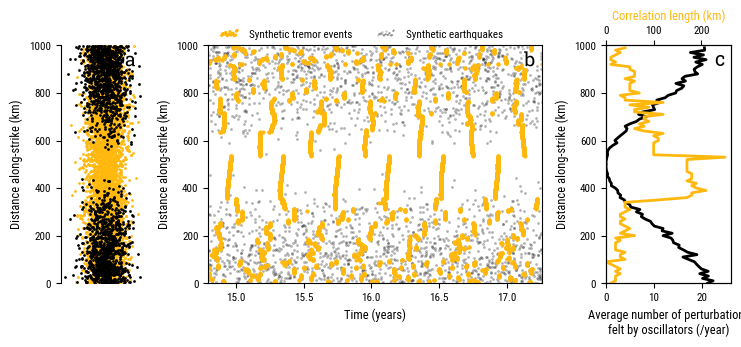

In [160]:
# Summary figure
with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 9])/2.54)
    gs = fig.add_gridspec(1, 3, width_ratios=[2, 8, 3])

    # --> Fake map
    ax = fig.add_subplot(gs[0])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)

    ax.set_ylabel('Distance along-strike (km)')
    ax.set_ylim(0, 1000)
    ev_y = np.random.randn(len(ev_x))  # fake "across-strike" location for illustration
    perturbation_y = np.random.randn(len(perturbation_idx))*1.2

    ax.plot(ev_y[::10], ev_x[::10], 'o', mfc=to_rgba('C2', 1), mec=[0,0,0,0], ms=2, zorder=0)
    ax.plot(perturbation_y[::10], perturbation_idx[::10] * L, 'o', mfc=to_rgba('k', 1), mec=[0,0,0,0], ms=2, zorder=1)

    ax.text(.9, .98, 'a', transform=ax.transAxes, fontsize=14, fontname='Roboto Slab', va='top', ha='right', path_effects=[pe.withStroke(linewidth=3, foreground='w')])

    # --> Time/space activity
    ax = fig.add_subplot(gs[1])
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Distance along-strike (km)')
    ax.set_xlim(30*osc_period*T/365, 35*osc_period*T/365)
    ax.set_ylim(0, 1000)

    ax.plot(perturbation_times * T / 365, perturbation_idx * L, 'o', ms=2, mfc=to_rgba('k', .3), mec=[0,0,0,0])
    ax.plot(ev_t / 365, ev_x, 'o', ms=2, color='C2')

    ax.scatter([], [], color='C2', label='Synthetic tremor events')
    ax.scatter([], [], s=2, color=to_rgba('k', .5), label='Synthetic earthquakes')

    ax.legend(bbox_to_anchor=(0, .98), loc='lower left', ncols=2, scatterpoints=20, markerscale=.2, scatteryoffsets=.5+np.random.randn(20)*.2)

    ax.text(.98, .98, 'b', transform=ax.transAxes, fontsize=14, fontname='Roboto Slab', va='top', ha='right', path_effects=[pe.withStroke(linewidth=3, foreground='w')])

    # --> Correlation distance / perturbation activity
    ax = fig.add_subplot(gs[2])
    ax.set_xlabel('Average number of perturbations\nfelt by oscillators (/year)')
    ax.set_ylabel('Distance along-strike (km)')
    ax.set_ylim(0, 1000)
    ax.set_xlim(0, 26)

    ax.plot(spatial_perturbation_yearly, x_bin_edges[:-1], 'k-', lw=2)

    ax_cc = ax.twiny()
    ax_cc.set_xlabel('Correlation length (km)', color='C2')
    ax_cc.plot(corr_length, x_bin_edges[:-1], 'C2-', lw=2)
    ax_cc.set_xlim(xmin=0)

    ax.text(.95, .98, 'c', transform=ax.transAxes, fontsize=14, fontname='Roboto Slab', va='top', ha='right')

    plt.tight_layout()
    plt.savefig('figures/simulation_summary.png', dpi=400)
    plt.savefig('figures/simulation_summary.pdf', dpi=400)
    plt.show()